In [1]:
import pandas as pd
import datetime
import numpy as np

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# Импорт денежных аггрегатов и денежной массы

- источник: [сайт ЦБ](https://cbr.ru/statistics/macro_itm/dkfs/monetary_agg/)

In [279]:
monetary_agg = pd.read_excel('../data/monetary_agg.xlsx').transpose()
monetary_agg.columns = monetary_agg.iloc[0]
monetary_agg = monetary_agg.iloc[1:]
monetary_agg = monetary_agg.loc[:, ['Денежный агрегат М0', 'Денежный агрегат М1']].dropna()
monetary_agg['date'] = pd.to_datetime(monetary_agg.index, format='%Y-%m-%d').date
monetary_agg = monetary_agg.reset_index()
monetary_agg = monetary_agg[['Денежный агрегат М0', 'Денежный агрегат М1', 'date']]

In [280]:
monetary_agg

"Денежные агрегаты*, млрд руб.",Денежный агрегат М0,Денежный агрегат М1,date
0,418.9,869.4,2001-01-01
1,379.7,805.8,2001-02-01
2,387.6,821.3,2001-03-01
3,399.0,852.5,2001-04-01
4,435.0,913.3,2001-05-01
...,...,...,...
277,16756.4,48595.1,2024-02-01
278,16708.8,49368.8,2024-03-01
279,16622.3,49338.0,2024-04-01
280,16738.2,50119.4,2024-05-01


In [281]:
m = pd.read_csv('../data/Денежная масса, млрд нац ден ед, Россия — Диаграмма.csv', sep=';')
m.date = pd.to_datetime(m.date, format='%d.%m.%Y').dt.date

m['date'] = m.date.apply(lambda x: datetime.date(year=x.year, month=x.month, day=1))

m = m.groupby('date', as_index=False).agg('mean')

In [282]:
m

,date,dataset,"Денежная масса, млрд нац ден ед, Россия"
0,1995-06-01,69779.0,152.8
1,1995-07-01,69779.0,162.4
2,1995-08-01,69779.0,173.6
3,1995-09-01,69779.0,182.0
4,1995-10-01,69779.0,186.6
...,...,...,...
331,2023-01-01,69779.0,81806.0
332,2023-02-01,69779.0,83151.0
333,2023-03-01,69779.0,84159.0
334,2023-04-01,69779.0,84418.0


In [283]:
m = m.merge(monetary_agg, on='date', how='inner')

In [284]:
m

,date,dataset,"Денежная масса, млрд нац ден ед, Россия",Денежный агрегат М0,Денежный агрегат М1
0,2001-01-01,69779.0,1114.8,418.9,869.4
1,2001-02-01,69779.0,1143.3,379.7,805.8
2,2001-03-01,69779.0,1178.0,387.6,821.3
3,2001-04-01,69779.0,1230.7,399.0,852.5
4,2001-05-01,69779.0,1237.2,435.0,913.3
...,...,...,...,...,...
264,2023-01-01,69779.0,81806.0,15435.7,44018.5
265,2023-02-01,69779.0,83151.0,15361.2,44964.6
266,2023-03-01,69779.0,84159.0,15576.6,45621.0
267,2023-04-01,69779.0,84418.0,15819.6,45350.5


In [285]:
m['Доля М0'] = m['Денежный агрегат М0'] / m['Денежная масса, млрд нац ден ед, Россия']
m['Доля М1'] = m['Денежный агрегат М1'] / m['Денежная масса, млрд нац ден ед, Россия']

In [116]:
m.to_csv('../data/денежные агрегаты.csv')

# Визуализация

Т.к М0 вложен в М1 то выберем что то одно из них

In [99]:
import matplotlib.pyplot as plt

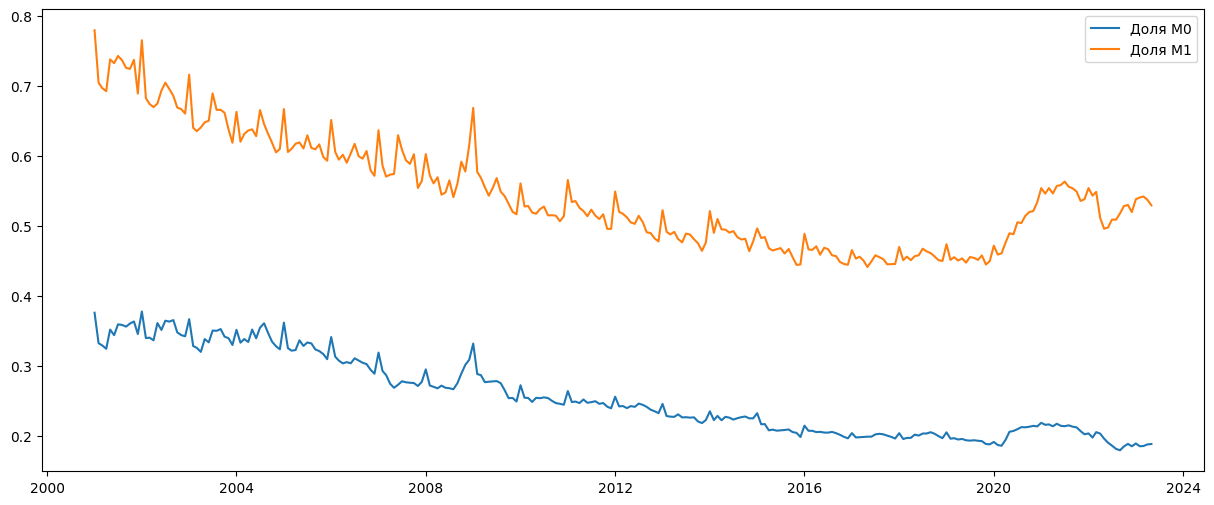

In [286]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(m.date, m['Доля М0'], label='Доля М0')
ax.plot(m.date, m['Доля М1'], label='Доля М1')

ax.legend()

# Импорт признаков ИПП

возьмем для ИПЦ:
- news
- curs
- interest_rate

In [289]:
df = pd.read_csv('../data/preprocessed_ipp_factors.csv')
df.date = pd.to_datetime(df.date).dt.date.apply(lambda x: datetime.date(year=x.year, month=x.month, day=1))
features = df[['date', 'news', 'curs', 'interest_rate']]

In [290]:
features

,date,news,curs,interest_rate
0,2015-01-01,-1.551464,65.153087,15.380952
1,2015-02-01,-1.756337,64.518174,13.789474
2,2015-03-01,-1.972270,60.363090,13.409091
3,2015-04-01,-1.537923,53.218695,13.575000
4,2015-05-01,-0.836183,50.467958,12.525000
...,...,...,...,...
103,2023-08-01,0.608112,95.285348,11.309524
104,2023-09-01,0.243075,96.622259,11.625000
105,2023-10-01,0.425872,97.122281,11.568182
106,2023-11-01,0.848450,90.412790,13.113636


# Импорт ИПЦ

In [291]:
ipc = pd.read_csv('../data/Базовый индекс потребительских цен.csv', sep=';')
ipc.date = pd.to_datetime(ipc.date, format='%d.%m.%Y').dt.date.apply(lambda x: datetime.date(year=x.year, month=x.month, day=1))

In [292]:
ipc

,dataset,date,"Базовый индекс потребительских цен, индекс, Россия"
0,69798,2003-01-01,1.0120
1,69798,2003-02-01,1.0088
2,69798,2003-03-01,1.0068
3,69798,2003-04-01,1.0063
4,69798,2003-05-01,1.0057
...,...,...,...
241,69798,2023-02-01,1.0013
242,69798,2023-03-01,1.0037
243,69798,2023-04-01,1.0031
244,69798,2023-05-01,1.0052


# Обьединение данных

In [293]:
df = ipc.merge(features, on='date').merge(m, on='date')
df = df.drop(columns=['dataset_x', 'dataset_y'])

In [294]:
df

,date,"Базовый индекс потребительских цен, индекс, Россия",news,curs,interest_rate,"Денежная масса, млрд нац ден ед, Россия",Денежный агрегат М0,Денежный агрегат М1,Доля М0,Доля М1
0,2015-01-01,1.0352,-1.551464,65.153087,15.380952,30906.0,7171.5,15341.4,0.232042,0.496389
1,2015-02-01,1.0235,-1.756337,64.518174,13.789474,30989.0,6700.3,14955.2,0.216215,0.482597
2,2015-03-01,1.0147,-1.972270,60.363090,13.409091,30825.0,6671.9,14921.0,0.216444,0.484055
3,2015-04-01,1.0080,-1.537923,53.218695,13.575000,31517.0,6540.9,14749.8,0.207536,0.467995
4,2015-05-01,1.0055,-0.836183,50.467958,12.525000,31742.0,6619.6,14753.7,0.208544,0.464801
...,...,...,...,...,...,...,...,...,...,...
96,2023-01-01,1.0030,-0.480049,68.875975,8.525000,81806.0,15435.7,44018.5,0.188687,0.538084
97,2023-02-01,1.0013,-0.273628,72.782750,8.277778,83151.0,15361.2,44964.6,0.184739,0.540758
98,2023-03-01,1.0037,0.084083,76.103586,8.083333,84159.0,15576.6,45621.0,0.185085,0.542081
99,2023-04-01,1.0031,0.001142,80.995543,8.425000,84418.0,15819.6,45350.5,0.187396,0.537214


In [295]:
df.columns = ['date', 'ipc', 'news', 'curs', 'interest_rate', 'money_supply', 'm0', 'm1', 'share_m0', 'share_m1']

In [172]:
df.to_csv('../data/ipc_preprocessed_factors.csv')

# Предобработка

In [296]:
features = df.columns[1:]

In [322]:
for feature in features:
    for i in range(1, 3 + 1):
        df[f'{feature}_lag_{i}'] = df[feature].shift(i)

df = df.fillna(method='pad')

df['ipc_lag_1'] = df['ipc_lag_1'] ** 2
df['ipc_lag_2'] = df['ipc_lag_2'] ** 2

In [323]:
df

,date,ipc,news,curs,interest_rate,money_supply,m0,m1,share_m0,share_m1,...,m0_lag_3,m1_lag_1,m1_lag_2,m1_lag_3,share_m0_lag_1,share_m0_lag_2,share_m0_lag_3,share_m1_lag_1,share_m1_lag_2,share_m1_lag_3
0,2015-01-01,1.0352,-1.551464,65.153087,15.380952,30906.0,7171.5,15341.4,0.232042,0.496389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-01,1.0235,-1.756337,64.518174,13.789474,30989.0,6700.3,14955.2,0.216215,0.482597,...,NaN,15341.4,NaN,NaN,0.232042,NaN,NaN,0.496389,NaN,NaN
2,2015-03-01,1.0147,-1.972270,60.363090,13.409091,30825.0,6671.9,14921.0,0.216444,0.484055,...,NaN,14955.2,15341.4,NaN,0.216215,0.232042,NaN,0.482597,0.496389,NaN
3,2015-04-01,1.0080,-1.537923,53.218695,13.575000,31517.0,6540.9,14749.8,0.207536,0.467995,...,7171.5,14921.0,14955.2,15341.4,0.216444,0.216215,0.232042,0.484055,0.482597,0.496389
4,2015-05-01,1.0055,-0.836183,50.467958,12.525000,31742.0,6619.6,14753.7,0.208544,0.464801,...,6700.3,14749.8,14921.0,14955.2,0.207536,0.216444,0.216215,0.467995,0.484055,0.482597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2023-01-01,1.0030,-0.480049,68.875975,8.525000,81806.0,15435.7,44018.5,0.188687,0.538084,...,14175.0,41484.6,41323.0,40601.7,0.184699,0.188152,0.184443,0.519812,0.529999,0.528303
97,2023-02-01,1.0013,-0.273628,72.782750,8.277778,83151.0,15361.2,44964.6,0.184739,0.540758,...,14669.8,44018.5,41484.6,41323.0,0.188687,0.184699,0.188152,0.538084,0.519812,0.529999
98,2023-03-01,1.0037,0.084083,76.103586,8.083333,84159.0,15576.6,45621.0,0.185085,0.542081,...,14740.3,44964.6,44018.5,41484.6,0.184739,0.188687,0.184699,0.540758,0.538084,0.519812
99,2023-04-01,1.0031,0.001142,80.995543,8.425000,84418.0,15819.6,45350.5,0.187396,0.537214,...,15435.7,45621.0,44964.6,44018.5,0.185085,0.184739,0.188687,0.542081,0.540758,0.538084


In [367]:
exog_var = [
    'curs',
    'interest_rate',
    'ipc_lag_1',
    'share_m0',
    'share_m1',
    'news',
]

<Axes: >

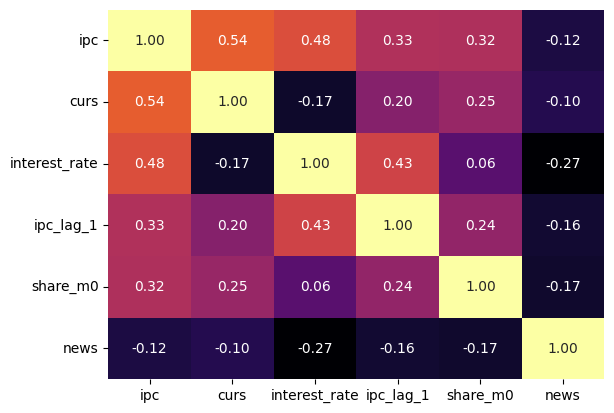

In [366]:
sns.heatmap(
    df[['ipc'] + exog_var].corr(),
    fmt=".2f",
    annot=True,
    cmap='inferno',
    cbar=False
)

решил в общем без лагов лучше, видимо индекс очень краткосрочный

In [326]:
df.drop(columns=['date']).corr().sort_values(by='ipc', ascending=False)[['ipc']].head(15)

,ipc
ipc,1.000000
curs,0.537138
interest_rate,0.481955
ipc_lag_1,0.331003
curs_lag_1,0.330100
share_m0,0.323756
share_m1_lag_2,0.319369
share_m1_lag_3,0.286375
share_m1_lag_1,0.280741
curs_lag_2,0.260603


Text(0, 0.5, 'ИПЦ')

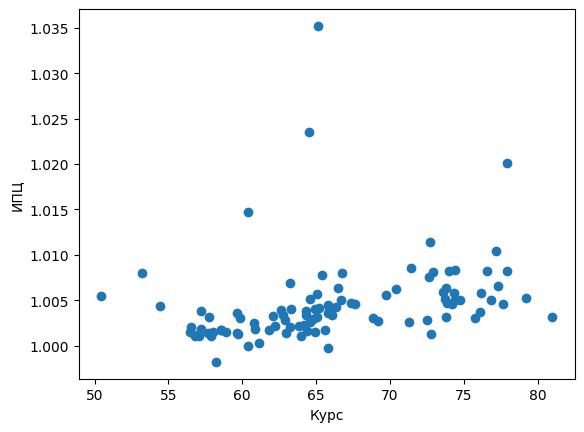

In [327]:
plt.scatter(df[df.curs < 100].curs, df[df.curs < 100].ipc)
plt.xlabel('Курс')
plt.ylabel('ИПЦ')

Text(0, 0.5, 'ИПЦ')

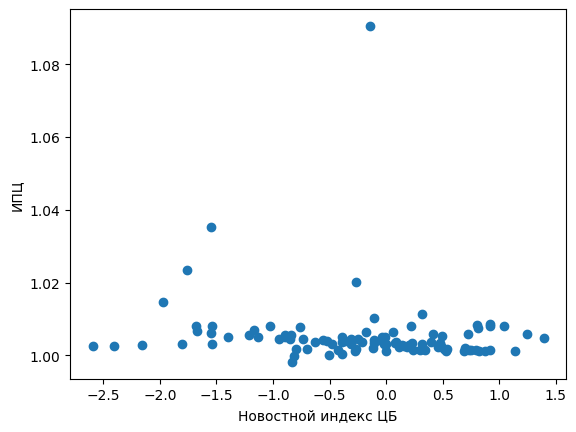

In [328]:
plt.scatter(df.news, df.ipc)
plt.xlabel('Новостной индекс ЦБ')
plt.ylabel('ИПЦ')

Text(0, 0.5, 'ИПЦ')

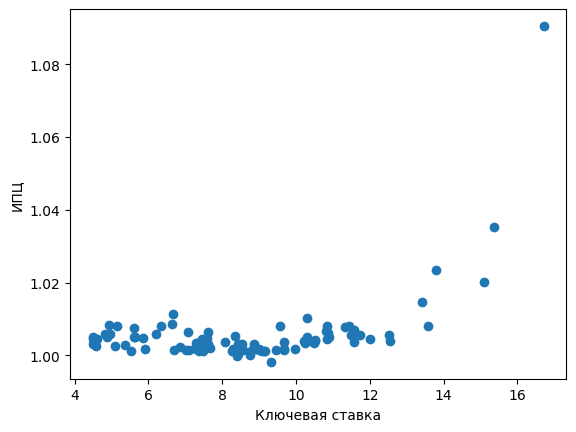

In [329]:
plt.scatter(df.interest_rate, df.ipc)
plt.xlabel('Ключевая ставка')
plt.ylabel('ИПЦ')

Text(0, 0.5, 'ИПЦ')

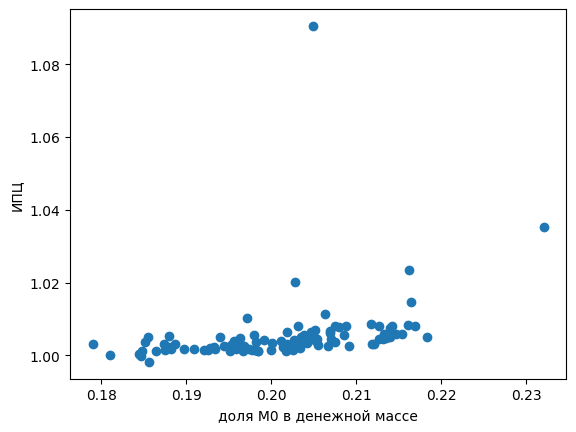

In [330]:
plt.scatter(df.share_m0, df.ipc)
plt.xlabel('доля М0 в денежной массе')
plt.ylabel('ИПЦ')

# Модель catboost

In [337]:
def train_test_split(exog_var, goal):
    X_train = df[df.date < datetime.date(year=2022, month=1, day=1)][exog_var].fillna(method='bfill')
    Y_train = df[df.date < datetime.date(year=2022, month=1, day=1)][goal].fillna(method='bfill')
    
    X_test = df[df.date >= datetime.date(year=2022, month=1, day=1)][exog_var]
    Y_test = df[df.date >= datetime.date(year=2022, month=1, day=1)][goal]
    
    return X_train, X_test, Y_train, Y_test

In [368]:
exog_var = [
    'curs',
    'news',
    'interest_rate',
    'ipc_lag_1',
    'share_m0',
]

In [369]:
X_train, X_test, Y_train, Y_test = train_test_split(exog_var, 'ipc')

model = CatBoostRegressor(verbose=False, loss_function='RMSE')

grid = {
    'iterations':    [6, 8, 16], 
    'depth':         [3, 6, 8],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}


res = model.grid_search(
    grid, X_train, Y_train, 
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True, verbose=0
)


bestTest = 0.9979634643
bestIteration = 5


bestTest = 0.9457364183
bestIteration = 5


bestTest = 0.5380772319
bestIteration = 5


bestTest = 0.02438452849
bestIteration = 5


bestTest = 0.00136551404
bestIteration = 2


bestTest = 0.9979660981
bestIteration = 5


bestTest = 0.9457617476
bestIteration = 5


bestTest = 0.5382474984
bestIteration = 5


bestTest = 0.02452281058
bestIteration = 5


bestTest = 0.001268428028
bestIteration = 5


bestTest = 0.9980120933
bestIteration = 5


bestTest = 0.94620405
bestIteration = 5


bestTest = 0.5412185157
bestIteration = 5


bestTest = 0.02758185452
bestIteration = 5


bestTest = 0.003801110421
bestIteration = 1


bestTest = 0.9981921944
bestIteration = 5


bestTest = 0.9479355166
bestIteration = 5


bestTest = 0.5528135367
bestIteration = 5


bestTest = 0.04174749831
bestIteration = 5


bestTest = 0.01867294573
bestIteration = 5


bestTest = 0.9983816333
bestIteration = 5


bestTest = 0.9497567865
bestIteration = 5


bestTest = 0.5649882177

In [358]:
res['params']

{'depth': 6, 'learning_rate': 1, 'l2_leaf_reg': 0.005, 'iterations': 6}

In [360]:
model = CatBoostRegressor(**res['params'], verbose = False)
model.fit(X_train, Y_train)

# Качество модели

In [312]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [362]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score:   {np.round(r2_score(Y_train, train_predict), 3)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(Y_train, train_predict), 3) * 100:0.1f}%')
print(f'mape test:  {np.round(mean_absolute_percentage_error(Y_test, test_predict), 3) * 100:0.1f}%')

r2_score:   0.993
mape train: 0.0%
mape test:  0.7%


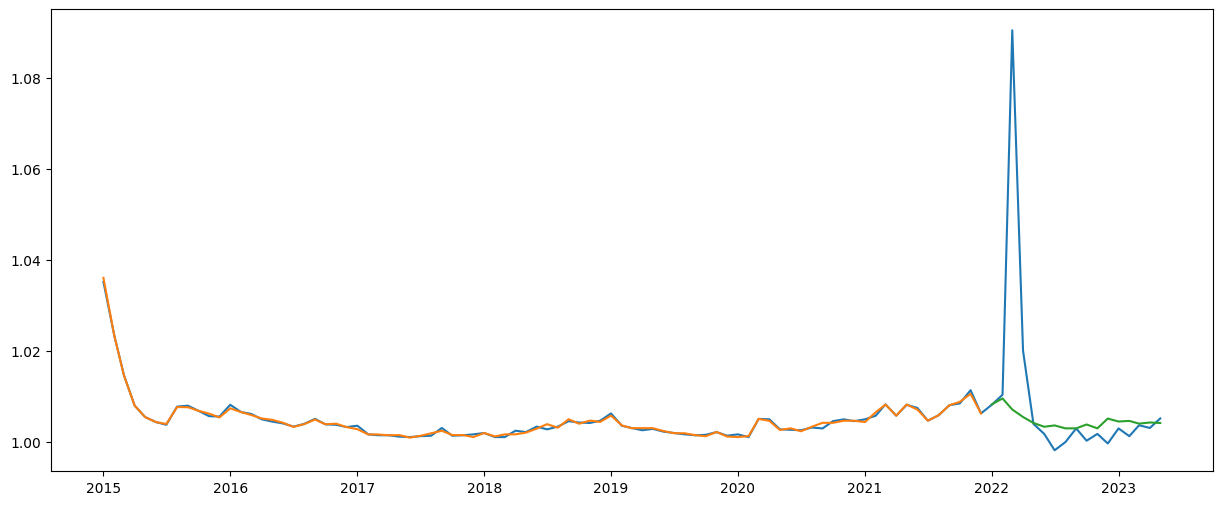

In [363]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.date, df.ipc)
ax.plot(df.date[:train_predict.shape[0]], train_predict, label='Train predict')
ax.plot(df.date[train_predict.shape[0]:], test_predict, label='Test predict')